## *Capstone Project One*: Iceberg or ship classification, [kaggle Statoil/C-CORE Iceberg Classifier Challenge](https://www.kaggle.com/c/statoil-iceberg-classifier-challenge)
January 2018

Author: [Yaqiong Zhang](https://www.linkedin.com/in/yaqiong-zhang-38bba2b4/)

## Abstract


## Table of Content
- [1 Introduction](#intro)
- [2 Analysis](#anal)
   - [2.1 Data import & basic data information ](#2.1)
   - [2.2 Basic image data processing - transfer the image channel  to a 75x75 array](#2.2)
   - [2.3 Plot the image data](#2.3)
   - [2.4 Image argumentation](#2.4)
   - [2.5 EDA with angle data](#2.5)
- [3 Image classification Models](#3)
   - [3.1 Convolutional neural network - basic model](#3.1)
   - [3.2 Convolutional neural network - with rotate data](#3.2)
   - [3.3 Convolutional neural network - with ImageDataGenerator from Keras](#3.3)
   - [3.4 Convolutional neural network - with cross validation](#3.4)
   - [3.5 Random forest - feature generated from a convolutional neural network](#3.5)
   - [3.6 Transfer learning - VGG16](#3.6)

<a id= "intro"></a>
## 1 Introduction



In the movie Titanic, the drifting icebergs were monitored by human eye, which is inefficient and not reliable. Nowadays, people use satellite data for the detecting drifting icebergs. This is especially important for the safety of ships or oil stations in a harsh environment.

The satellite radar works as bouncing a signal off an object and receive the backscattering signal from the object. The received signal is translated into an image. And through that image we can apply classifiers to detect if there are threaten icebergs in that image area. 

There are several factors to be consider: first, the radar signal contains H and V parts. During the backscattering on an object, the H and V parts will change differently due to the physical propeties of the object. Thus, the change of the two parts contains important information [[1]](http://www.nrcan.gc.ca/node/9567). In this kaggle challenge, dual-polarization image was give with two channels: HH (horizonal transmit and horizontal receive) and HV (horizonal transmit and vertical receive). Second, the image is affected by the weather conditions such as the speed of the wind. High wind will generate a brighter background and low wind will generate a darker background. Third is the incidence angle the radar transmit and receive data. The ocean background will be darker at a higher incident angle.

Client of the project would be remote sensing companies like [C-CORE](https://www.c-core.ca/).

<a id= "anal"></a>
## 2 Analysis
<a id= "2.1"></a>
### 2.1 Data import & basic data information
There are two data file available from this kaggle challenge: train.json and test.json. The test.json contains data without labels. The predicted label from a team will be evaluated in the public Leaderboard which contains 20% of the test data. All the predicted label will be evaluated after the deadline of the challenge (January 23, 2018)

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
#load data
train = pd.read_json("../input/data/processed/train.json")
test = pd.read_json("../input/data/processed/test.json")

In [3]:
#data exploration
train.head()

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


This indicate that this dataframe have 5 columns.

In [4]:
test.tail()

,band_1,band_2,id,inc_angle
8419,"[-25.082357, -26.71583, -24.599827, -25.082571...","[-25.860718, -23.29442, -25.860861, -25.334354...",16ee9b50,34.795500
8420,"[-21.031391143798828, -21.031391143798828, -21...","[-23.755836486816406, -23.755836486816406, -23...",5a599eb7,32.246683
8421,"[-28.609278, -26.514626, -26.514679, -26.83061...","[-28.609278, -29.437183, -30.35239, -31.375494...",df30d6dd,39.503200
8422,"[-27.068821, -27.068892, -23.970854, -22.38730...","[-29.991381, -29.163599, -24.886002, -27.71266...",18af95b1,33.638000
8423,"[-25.438865661621094, -25.438865661621094, -25...","[-23.85527801513672, -23.85527801513672, -23.8...",27d788c8,36.758181


In [5]:
#look at the data types
for idx, feature in enumerate(train.columns):
    print (feature, ": ", train.dtypes[idx])

band_1 :  object
band_2 :  object
id :  object
inc_angle :  object
is_iceberg :  int64


In [6]:
train.describe()

,is_iceberg
count,1604.000000
mean,0.469451
std,0.499222
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [7]:
len(train['band_1'][0])

5625

The above results indicate that there are 1604 datasets in this train dataset. There are 8423 data sets in the test dataset. And there are 46.9451% of the images are iceberg imgage in the training dataset.

Band_1 is the HH channel, and band_2 is the HV channel. There are 5625 data point in the image data, which can be convert into a 75x75 array.
<a id= "2.2"></a>
### 2.2 Basic image data processing - transfer the image channel  to a 75x75 array

In [8]:
#process the training data
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis], X_band_2[:, :, :, np.newaxis],((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], axis=-1)

#process the testing data
X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis]
                          , X_band_test_2[:, :, :, np.newaxis],((X_band_test_1+X_band_test_2)/2)[:, :, :, np.newaxis]], axis=-1)

<a id= "2.3"></a>
### 2.3 Plot the image data

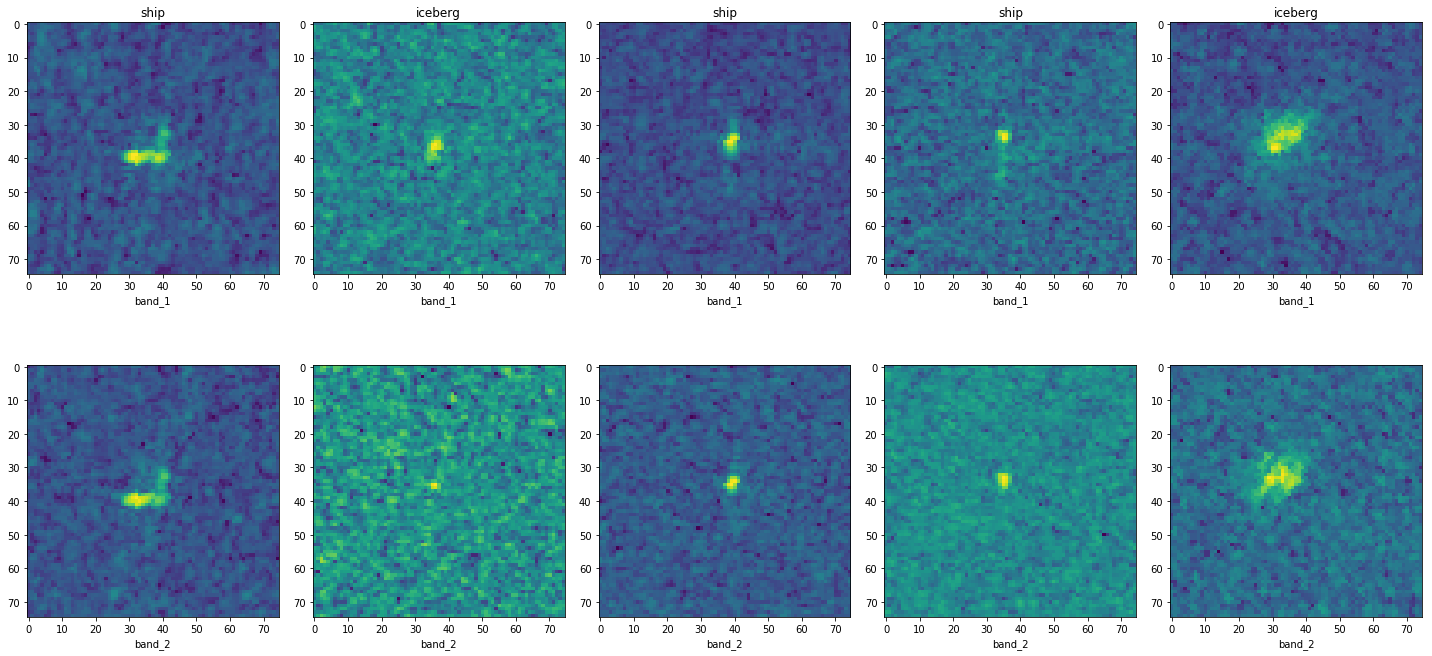

In [9]:
plt.figure(figsize=(20,10))
for example in range(1,6):
   
    plt.subplot(2,5,example)
    plt.imshow(X_band_1[example])
    plt.xlabel('band_1')
    
    if train['is_iceberg'][example] == 1:
        plt.title('iceberg')
    else:
        plt.title('ship')
        
    plt.subplot(2,5,5+example)
    plt.imshow(X_band_2[example])
    plt.xlabel('band_2')

plt.tight_layout()

<a id= "2.4"></a>
### 2.4 Image argumentation
#### Rotate the images 90 degrees and 180 degrees respectively (to increase the amount of training data)
Data argumentation is important when we only have a limit number of training samples and complex model which tends to overfit. Image argumentation is used to generate more images for training purpose. For example, we can rotate the image at certain angle and it still represent the same sample, but the model may be able to learn some new features from the image. Keras have a build-in function for image argumentation: [ImageDataGenerator](https://keras.io/preprocessing/image/). In this section, we shows an example of manually rotate the image to rotate the image 90 degree and 180 degree.

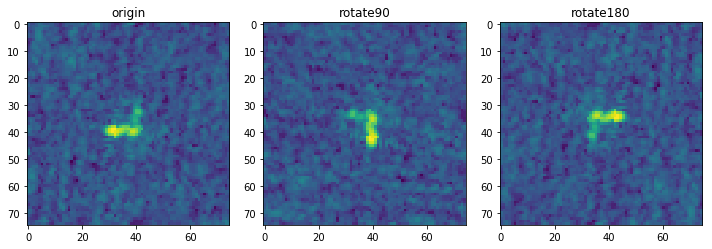

In [10]:
plt.figure(figsize=(10,5))

plt.imshow(X_band_1[1])
plt.subplot(1,3,1)
plt.imshow(X_band_1[1])
plt.title('origin')

X_band_1_rotate90 = np.array([np.rot90(image) for image in X_band_1])
X_band_2_rotate90 = np.array([np.rot90(image) for image in X_band_2])
plt.subplot(1,3,2)
plt.imshow(X_band_1_rotate90[1])
plt.title('rotate90')

X_band_1_rotate180 = np.array([np.rot90(image,2) for image in X_band_1])
X_band_2_rotate180 = np.array([np.rot90(image,2) for image in X_band_2])
plt.subplot(1,3,3)
plt.imshow(X_band_1_rotate180[1])
plt.title('rotate180')

plt.tight_layout()

<a id= "2.5"></a>
### 2.5 EDA with angle data

Building

<a id= "3"></a>
## 3 Image classification Models
In this chapter, we will apply and compare two very popular classification algorithm for image classification: random forest and convolutional neural network.


<a id= "3.1"></a>
### 3.1 Convolutional neural network - basic model
Image classification or object recognition is a simple and nature thing to human beings, but it's not so easy for computers. The same object may look quite different in two photos and it's hard for computer algorithms to learn that. However, since 2010, this field has made tremendous progress using Convolutional neural networks (Convnet), and also thanks to the improvement of the computational speed and some large image database like [ImageNet](http://www.image-net.org/). 

We will use neural network library [Keras](https://keras.io/) in this section. And first, we will build a convolutional neural network (convnet) and train it using the training dataset. The architecture of the convnet is inspired from prevouse work in [Welcome to deep learning (CNN 99%) by Peter Grenholm](https://www.kaggle.com/toregil/welcome-to-deep-learning-cnn-99).

Learning resources:
1. [Stanford U. cs231n](http://cs231n.stanford.edu/)

Reference resources for the models:
1. [Keras Model for Beginners (0.210 on LB)+EDA+R&D by DeveshMaheshwari](https://www.kaggle.com/devm2024/keras-model-for-beginners-0-210-on-lb-eda-r-d)
2.  [Welcome to deep learning (CNN 99%) by Peter Grenholm](https://www.kaggle.com/toregil/welcome-to-deep-learning-cnn-99)
3.  [Display Deep Learning Model Training History in Keras by Jason Brownlee](https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/)
4. [Evaluate the Performance Of Deep Learning Models in Keras by Jason Brownlee](https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/)

In [11]:
import keras
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation, BatchNormalization
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping,ReduceLROnPlateau


Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [12]:
#define our model
def getModel():
    #Building the model
    gmodel=Sequential()
    #Conv Layer 1
    gmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 3)))
    gmodel.add(BatchNormalization())
    gmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu'))
    gmodel.add(BatchNormalization())
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    gmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu'))
    gmodel.add(BatchNormalization())
    gmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu'))
    gmodel.add(BatchNormalization())
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))
    
    #Flatten the data for upcoming dense layers
    gmodel.add(Flatten())

    #Dense Layers
    gmodel.add(Dense(512))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Dense Layer 2
    gmodel.add(Dense(256))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Sigmoid Layer
    gmodel.add(Dense(1))
    gmodel.add(Activation('sigmoid'))

    mypotim=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    gmodel.compile(loss='binary_crossentropy',
                  optimizer=mypotim,
                  metrics=['accuracy'])
    gmodel.summary()
    return gmodel


def get_callbacks(filepath, patience):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

In [13]:
target_train=train['is_iceberg']

from sklearn.model_selection import train_test_split
X_train_cv, X_valid, y_train_cv, y_valid = train_test_split(X_train, target_train, random_state=1, train_size=0.9)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Shared Value: X_train_cv, X_valid, y_train_cv, y_valid = train_test_split(X_train, target_train, random_state=1, train_size=0.9)

In [14]:
file_path = "model_weights.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=10)

In [15]:
import os
gmodel=getModel()
history = gmodel.fit(X_train_cv, y_train_cv,
          batch_size=16,
          epochs=100,
          verbose=1,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 73, 73, 64)        1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 73, 73, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 71, 71, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        36928     
__________

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


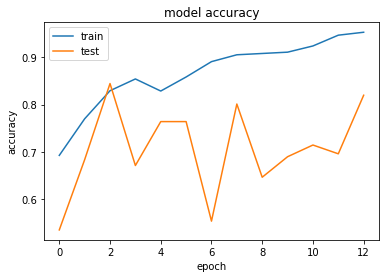

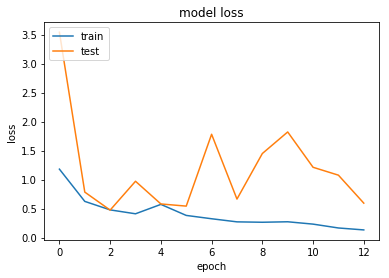

In [16]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
gmodel.load_weights(filepath=file_path)
score = gmodel.evaluate(X_valid, y_valid, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


161/161 [==============================] - 0s 2ms/step
Test loss: 0.473571754271
Test accuracy: 0.844720496894


#### test records: (Jan. 21, 2018)

161/161 [==============================] - 0s 2ms/step

Test loss: 0.405201216543
Test accuracy: 0.863354037267

161/161 [==============================] - 0s 2ms/step

Test loss: 0.240935826775
Test accuracy: 0.88198757764

161/161 [==============================] - 0s 2ms/step

Test loss: 0.401744958658
Test accuracy: 0.807453416149

161/161 [==============================] - 0s 2ms/step

Test loss: 0.473571754271
Test accuracy: 0.844720496894


<a id= "3.2"></a>
### 3.2 Convolutional neural network - with rotate data
We observed high overfitting and "too good" val_accuracy = 100% when we use train_size = 0.9 in this section. So, we changed it to 0.7, which means more data will pass to the validation process.


In [18]:
X_train_rotate90 = np.concatenate([X_band_1_rotate90[:, :, :, np.newaxis], X_band_2_rotate90[:, :, :, np.newaxis],((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], axis=-1)
X_train_rotate180 = np.concatenate([X_band_1_rotate180[:, :, :, np.newaxis], X_band_2_rotate180[:, :, :, np.newaxis],((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], axis=-1)

X_train_rotate = np.concatenate([X_train, X_train_rotate90, X_train_rotate180],axis = 0)
target_train_rotate=np.concatenate([train['is_iceberg'],train['is_iceberg'],train['is_iceberg']],axis = 0)

In [19]:
X_train_cv_rotate, X_valid_rotate, y_train_cv_rotate, y_valid_rotate = train_test_split(X_train_rotate, target_train_rotate, random_state=1, train_size=0.7)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


#### Shared value: X_train_cv_rotate, X_valid_rotate, y_train_cv_rotate, y_valid_rotate = train_test_split(X_train_rotate, target_train_rotate, random_state=1, train_size=0.7)

In [20]:
file_path_rotate = "model_weights_rotate.hdf5"
callbacks_rotate = get_callbacks(filepath=file_path_rotate, patience=10)


In [21]:
gmodel=getModel()
history_rotate = gmodel.fit(X_train_cv_rotate, y_train_cv_rotate,
          batch_size=24,
          epochs=100,
          verbose=1,
          validation_data=(X_valid_rotate, y_valid_rotate),
          callbacks=callbacks_rotate)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 73, 73, 64)        1792      
_________________________________________________________________
batch_normalization_5 (Batch (None, 73, 73, 64)        256       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 71, 71, 64)        36928     
_________________________________________________________________
batch_normalization_6 (Batch (None, 71, 71, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 33, 33, 64)        36928     
__________

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


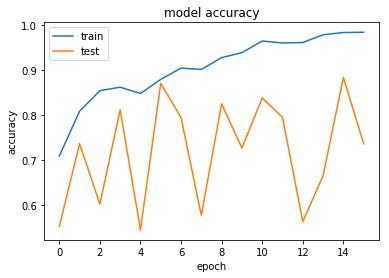

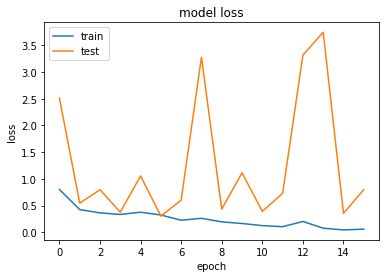

In [22]:
print(history_rotate.history.keys())
# summarize history for accuracy
plt.plot(history_rotate.history['acc'])
plt.plot(history_rotate.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_rotate.history['loss'])
plt.plot(history_rotate.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
gmodel.load_weights(filepath=file_path_rotate)
score = gmodel.evaluate(X_valid, y_valid, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


161/161 [==============================] - 0s 956us/step
Test loss: 0.353557794612
Test accuracy: 0.83850931677


#### Test records:

1444/1444 [==============================] - 1s 996us/step

Test loss: 0.110237692046
Test accuracy: 0.985457063712

After changing the train_size from 0.9 to 0.7, the results is still "too good". Will not be as good when tested on new data from my experience.

1444/1444 [==============================] - 1s 913us/step

Test loss: 0.116922409504
Test accuracy: 0.979916897507

161/161 [==============================] - 0s 956us/step

Test loss: 0.353557794612
Test accuracy: 0.83850931677



<a id= "3.3"></a>
### 3.3 Convolutional neural network - with ImageDataGenerator from Keras
ImageDataGenerator is the function built in the Keras library to do the image data argumentation, so we do not need to do it manually so I did to rotate the image 90 degree and 180 degree.

Let's see how it works. We will use the dataset without rotated images.

In [24]:
from keras.preprocessing.image import ImageDataGenerator

In [25]:
file_path_img_gen = "model_weights_imageDataGenerator.hdf5"
callbacks_img_gen = get_callbacks(filepath=file_path_img_gen, patience=10)

In [26]:
datagen = ImageDataGenerator(
                             rotation_range = 20,
                             width_shift_range = 0.1,
                             height_shift_range = 0.1,
                             zoom_range = 0.2)

#### Reference: the above settings from: https://www.kaggle.com/c/statoil-iceberg-classifier-challenge/discussion/45265#261232

In [27]:
gmodel=getModel()
gmodel.fit_generator(datagen.flow(X_train_cv, y_train_cv, batch_size=24),
                     
                    steps_per_epoch=len(X_train_cv) / 24, 
                     
                    epochs=100,
                    validation_data=(X_valid, y_valid),
                    validation_steps=len(X_valid) / 24,
                    callbacks=callbacks_img_gen)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 73, 73, 64)        1792      
_________________________________________________________________
batch_normalization_9 (Batch (None, 73, 73, 64)        256       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 71, 71, 64)        36928     
_________________________________________________________________
batch_normalization_10 (Batc (None, 71, 71, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 33, 33, 64)        36928     
__________

61/60 [==============================] - 5s 89ms/step - loss: 0.2763 - acc: 0.8873 - val_loss: 0.3782 - val_acc: 0.8075
Epoch 40/100
61/60 [==============================] - 5s 90ms/step - loss: 0.4465 - acc: 0.8621 - val_loss: 1.4995 - val_acc: 0.6025


In [28]:
gmodel.load_weights(filepath=file_path_img_gen)
score = gmodel.evaluate(X_valid, y_valid, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

161/161 [==============================] - 0s 941us/step
Test loss: 0.209169077458
Test accuracy: 0.937888198758


#### Test records:
161/161 [==============================] - 0s 1ms/step

Test loss: 0.220500707626
Test accuracy: 0.900621118012

1444/1444 [==============================] - 1s 913us/step

Test loss: 0.427081537049
Test accuracy: 0.799861495845


<a id= "3.4"></a>
### 3.4 Convolutional neural network - with cross validation
Cross validation (cv) is important when we do not have enough training data, because it use all the training data. Also, it help to decreas overfitiing, so the model will work well on predicting results of new testing data.

There are several ways to use cv. First, we can use cv to validate if the set of hyperparameter is better from another. By using cv, we can more confidentially say one set is better than the other since cv can get a statistic aspect and avoid judging the flutuating results from different initializations. Second, we can use cv to generate different sets of predicted results and average them (bagging ensemble ?) to get a better overall score.

This section, we will focus on the second kind of cv. reference: https://www.kaggle.com/jirivrany/my-best-single-model-simple-cnn-lb-0-1541

In [29]:
from sklearn.model_selection import StratifiedKFold

In [31]:
# K fold CV training
kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)
score_cv = []
for fold_n, (train, test) in enumerate(kfold.split(X_train, target_train)):
    print("FOLD nr: ", fold_n)
    model = getModel()
    
    MODEL_FILE = 'JirkaV/mdl_simple_k{}_wght.hdf5'.format(fold_n)
    batch_size = 32
    mcp_save = ModelCheckpoint(MODEL_FILE, save_best_only=True, monitor='val_loss', mode='min')
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, epsilon=1e-4, mode='min')

    model.fit(X_train[train], target_train[train],
        batch_size=24,
        epochs=30,
        verbose=1,
        validation_data=(X_train[test], target_train[test]),
        callbacks=[mcp_save, reduce_lr_loss])
    
    model.load_weights(filepath = MODEL_FILE)
    score = model.evaluate(X_train[test], target_train[test], verbose=1)
    score_cv.append(score[0])
    print('\n Val score:', score[0])
    print('\n Val accuracy:', score[1])
    


#     SUBMISSION = 'JirkaV/sub_simple_v1_{}.csv'.format(fold_n)

#     pred_test = model.predict(X_test)

#     submission = pd.DataFrame({'id': df_test["id"], 'is_iceberg': pred_test.reshape((pred_test.shape[0]))})
#     print(submission.head(10))

#     submission.to_csv(SUBMISSION, index=False)
#     print("submission saved")


FOLD nr:  0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 73, 73, 64)        1792      
_________________________________________________________________
batch_normalization_17 (Batc (None, 73, 73, 64)        256       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 71, 71, 64)        36928     
_________________________________________________________________
batch_normalization_18 (Batc (None, 71, 71, 64)        256       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 33, 33, 64)        36928    

Train on 803 samples, validate on 801 samples
Epoch 1/30
803/803 [==============================] - 6s 8ms/step - loss: 4.3596 - acc: 0.5504 - val_loss: 7.5660 - val_acc: 0.5306
Epoch 2/30
803/803 [==============================] - 4s 5ms/step - loss: 0.9895 - acc: 0.6725 - val_loss: 7.5660 - val_acc: 0.5306
Epoch 3/30
803/803 [==============================] - 4s 5ms/step - loss: 0.5368 - acc: 0.7659 - val_loss: 0.8810 - val_acc: 0.5980
Epoch 4/30
803/803 [==============================] - 4s 5ms/step - loss: 0.4796 - acc: 0.8157 - val_loss: 1.0652 - val_acc: 0.6692
Epoch 5/30
803/803 [==============================] - 4s 5ms/step - loss: 0.3819 - acc: 0.8456 - val_loss: 0.8966 - val_acc: 0.6367
Epoch 6/30
803/803 [==============================] - 4s 5ms/step - loss: 0.4612 - acc: 0.8394 - val_loss: 0.4445 - val_acc: 0.7840
Epoch 7/30
803/803 [==============================] - 4s 5ms/step - loss: 0.4178 - acc: 0.8493 - val_loss: 1.2849 - val_acc: 0.6592
Epoch 8/30
803/803 [==========

In [32]:
for fold_n, number in enumerate(score_cv):
    print ("FOLD nr:", fold_n, "test loss:", number)
    
print ('Average test loss:', np.mean(score_cv), "test loss std:", np.std(score_cv))

FOLD nr: 0 test loss: 0.37097169856
FOLD nr: 1 test loss: 0.409601541941
Average test loss: 0.39028662025 test loss std: 0.0193149216904


In [ ]:
# wdir = 'JirkaV/'
# stacked_1 = pd.read_csv(wdir + 'sub_simple_v1_0.csv')
# stacked_2 = pd.read_csv(wdir + 'sub_simple_v1_1.csv')
# stacked_3 = pd.read_csv(wdir + 'sub_simple_v1_2.csv')
# stacked_4 = pd.read_csv(wdir + 'sub_simple_v1_3.csv')
# stacked_5 = pd.read_csv(wdir + 'sub_simple_v1_4.csv')
# stacked_6 = pd.read_csv(wdir + 'sub_simple_v1_5.csv')
# stacked_7 = pd.read_csv(wdir + 'sub_simple_v1_6.csv')
# stacked_8 = pd.read_csv(wdir + 'sub_simple_v1_7.csv')
# stacked_9 = pd.read_csv(wdir + 'sub_simple_v1_8.csv')
# stacked_10 = pd.read_csv(wdir + 'sub_simple_v1_9.csv')
# sub = pd.DataFrame()
# sub['id'] = stacked_1['id']
# sub['is_iceberg'] = np.exp(np.mean(
#     [
#         stacked_1['is_iceberg'].apply(lambda x: np.log(x)),
#         stacked_2['is_iceberg'].apply(lambda x: np.log(x)),
#         stacked_3['is_iceberg'].apply(lambda x: np.log(x)),
#         stacked_4['is_iceberg'].apply(lambda x: np.log(x)),
#         stacked_5['is_iceberg'].apply(lambda x: np.log(x)),
#         stacked_6['is_iceberg'].apply(lambda x: np.log(x)),
#         stacked_7['is_iceberg'].apply(lambda x: np.log(x)),
#         stacked_8['is_iceberg'].apply(lambda x: np.log(x)),
#         stacked_9['is_iceberg'].apply(lambda x: np.log(x)),
#     b    stacked_10['is_iceberg'].apply(lambda x: np.log(x)),
#         ], axis=0))

# sub.to_csv(wdir + 'final_ensemble_JirkaVrany.csv', index=False, float_format='%.6f')    

<a id= "3.5"></a>
### 3.5 Random forest - feature generated from a convolutional neural network
Convnet may be a good feature finder for a tree model. Since it scan the image patch by patch, so it may get some feature in that patch, not a single pixel, which may contain too much noise. We load the weight trained in section 3.1 of this notebook and use the weights of layers upto the flatten layer.

In [33]:
def getModel_rf():
    
    gmodel=Sequential()
    
    #Conv Layer 1
    gmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 3)))
    gmodel.add(BatchNormalization())
    gmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu'))
    gmodel.add(BatchNormalization())
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.4))

    gmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu'))
    gmodel.add(BatchNormalization())
    gmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu'))
    gmodel.add(BatchNormalization())
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.4))
    
    #Flatten the data for upcoming dense layers
    gmodel.add(Flatten())

    gmodel.summary()
    return gmodel

In [34]:
gmodel=getModel_rf()
gmodel.load_weights('model_weights.hdf5',by_name=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 73, 73, 64)        1792      
_________________________________________________________________
batch_normalization_25 (Batc (None, 73, 73, 64)        256       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 71, 71, 64)        36928     
_________________________________________________________________
batch_normalization_26 (Batc (None, 71, 71, 64)        256       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 35, 35, 64)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 33, 33, 64)        36928     
__________

In [35]:
rf_gen = gmodel.predict(X_train)

In [36]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=500, oob_score=True)

rf = rf.fit(rf_gen, target_train)
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))

Our OOB prediction of accuracy is: 79.30174563591022%


#### Test record:
Our OOB prediction of accuracy is: 79.30174563591022%

<a id= "3.6"></a>
### 3.6 Transfer learning - VGG16
Training a new Convnet can be time_consuming, and there are a lot of hyperparameters to be decided as well as the architecture of it. We then moved forward to transfer learning, which means we use the some already trained Convnet and adjust it to solve this problem. Because those pre-trained covnet contains features captures which maybe useful in this problem. VGG16 is a well known pre-trained convnet which won 2014 ImageNet challenge.

Learning resource:
1. [Building powerful image classification models using very little data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)

In [37]:
from keras.applications.vgg19 import VGG19
from keras import applications

In [38]:
def train_top_model(input_shape):
    
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    mypotim=Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer=mypotim,
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    #model.summary()
    return model

In [39]:
file_path_VGG16 = 'top_model_weights_path.h5'
callbacks_VGG16 = get_callbacks(file_path_VGG16,patience=10)

In [40]:
VGGmodel = applications.VGG16(include_top=False, weights='imagenet')

X_train_VGG16 = VGGmodel.predict(X_train_cv)
X_valid_VGG16 = VGGmodel.predict(X_valid)

input_shape=X_train_VGG16.shape[1:]

In [41]:
model = train_top_model(input_shape)

model.fit(X_train_VGG16, y_train_cv,
          epochs=30,
          batch_size=24,
          verbose=1,
          validation_data=(X_valid_VGG16, y_valid),
          callbacks=callbacks_VGG16)

model.load_weights(filepath=file_path_VGG16)
                
scores = model.evaluate(X_valid_VGG16, y_valid, verbose=1)

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Train on 1443 samples, validate on 161 samples
Epoch 1/30
1443/1443 [==============================] - 2s 1ms/step - loss: 0.7802 - acc: 0.5787 - val_loss: 0.4597 - val_acc: 0.7640
Epoch 2/30
1443/1443 [==============================] - 1s 371us/step - loss: 0.5712 - acc: 0.6965 - val_loss: 0.4205 - val_acc: 0.7702
Epoch 3/30
1443/1443 [==============================] - 1s 370us/step - loss: 0.5152 - acc: 0.7193 - val_loss: 0.3989 - val_acc: 0.7950
Epoch 4/30
1443/1443 [==============================] - 1s 366us/step - loss: 0.4427 - acc: 0.7838 - val_loss: 0.3767 - val_acc: 0.8012
Epoch 5/30
1443/1443 [==============================] - 0s 301us/step - loss: 0.4256 - acc: 0.7949 - val_loss: 0.3812 - val_acc: 0.8012
Epoch 6/30
1443/1443 [==============================] - 1s 369us/step - loss: 0.4171 - acc: 0.7803 - val_loss: 0.3709 - val_acc: 0.8075
Epoch 7/30
1443/1443 [==============================] - 1s 369us/step - loss: 0.3804 - acc: 0.8170 - val_loss: 0.3640 - val_acc: 0.8137
Epo

### fine-tuning

In [42]:
def model_plus():
    
    base_model = applications.VGG16(weights='imagenet', include_top=False,input_shape=(75,75,3))
    # build a classifier model to put on top of the convolutional model
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(1024, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1, activation='sigmoid'))
    
    # note that it is necessary to start with a fully-trained
    # classifier, including the top classifier,
    # in order to successfully do fine-tuning
    
    
    top_model.load_weights(file_path_VGG16)
    # add the model on top of the convolutional base
    #model.add(top_model)
    
    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
    # set the first 25 layers (up to the last conv block)
    # to non-trainable (weights will not be updated)
    
    
    for layer in model.layers[:-5]:
        layer.trainable = False
    # compile the model with a SGD/momentum optimizer
    # and a very slow learning rate.
    
    
    mypotim=Adam(lr=1e-6, beta_1=0.7, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss='binary_crossentropy',
                  optimizer=mypotim,
                  metrics=['accuracy'])
    return model

In [43]:
file_path_VGG16_finetuning = "model_weights_VGG16_finetuning.hdf5"
callbacks_VGG16_finetuning = get_callbacks(file_path_VGG16_finetuning, 10)

In [44]:
model = model_plus()
history = model.fit(X_train_cv, y_train_cv,
          epochs=30,
          batch_size=24,
          verbose=1,
          validation_data=(X_valid, y_valid),
          callbacks = callbacks_VGG16_finetuning)

model.load_weights(filepath=file_path_VGG16_finetuning)
    
scores = model.evaluate(X_valid, y_valid, verbose=1)

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Train on 1443 samples, validate on 161 samples
Epoch 1/30
1443/1443 [==============================] - 9s 6ms/step - loss: 0.3415 - acc: 0.8392 - val_loss: 0.3582 - val_acc: 0.8137
Epoch 2/30
1443/1443 [==============================] - 6s 4ms/step - loss: 0.3288 - acc: 0.8468 - val_loss: 0.3539 - val_acc: 0.8137
Epoch 3/30
1443/1443 [==============================] - 6s 4ms/step - loss: 0.3184 - acc: 0.8468 - val_loss: 0.3498 - val_acc: 0.8261
Epoch 4/30
1443/1443 [==============================] - 6s 4ms/step - loss: 0.3020 - acc: 0.8600 - val_loss: 0.3465 - val_acc: 0.8199
Epoch 5/30
1443/1443 [==============================] - 6s 4ms/step - loss: 0.3211 - acc: 0.8489 - val_loss: 0.3452 - val_acc: 0.8323
Epoch 6/30
1443/1443 [==============================] - 5s 3ms/step - loss: 0.2957 - acc: 0.8656 - val_loss: 0.3471 - val_acc: 0.8261
Epoch 7/30
1443/1443 [==============================] - 6s 4ms/step - loss: 0.2909 - acc: 0.8711 - val_loss: 0.3446 - val_acc: 0.8261
Epoch 8/30
1443

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


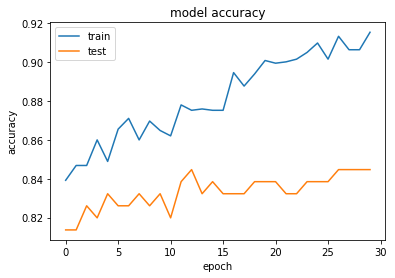

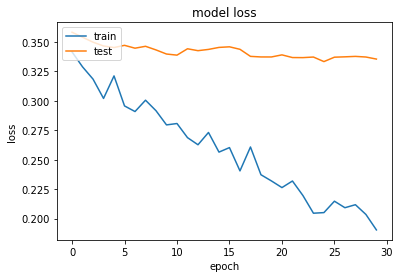

In [45]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Test records:
Test loss: 0.333277187441
Test accuracy: 0.83850931677